### Import Dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [2]:
default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
forcing_namelist = list(default_params.columns)

param_categories = {}
param_categories['other_wmghgs'] = ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8','carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methyl_bromide', 'methyl_chloride', 'nf3', 'sf6', 'so2f2', 'halon1202']
param_categories['carbon_dioxide'] = ['carbon_dioxide']
param_categories['methane'] = ['methane']
param_categories['nitrous_oxide'] = ['nitrous_oxide']
param_categories['trop_o3'] = [x for x in forcing_namelist if '|trop_o3' in x]
param_categories['strat_o3'] = [x for x in forcing_namelist if '|strat_o3' in x]
param_categories['strat_h2o'] = [x for x in forcing_namelist if '|strat_h2o' in x]
param_categories['ari'] = ['so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3','oc','nox_avi']
param_categories['aci'] = ['so2|aci','oc|aci','bc|aci']
param_categories['aer'] = param_categories['aci'] + param_categories['ari']
param_categories['bc_on_snow'] = ['bc|bc_on_snow']
param_categories['contrails'] = ['nox_avi|contrails']

## Import datasets

In [3]:
# MAGICC7.1.0.beta RCMIP runs
magicc_scm = pd.read_csv('/home/leachl/Documents/Datasets/RCMIP/rcmip/data/results/phase-1/magicc7/rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv').set_index(['Region','Scenario','Variable'])
magicc_scm.iloc[:,3:] = magicc_scm.iloc[:,3:].apply(pd.to_numeric)
magicc_scm.columns = list(magicc_scm.columns)[:3] + [int(x) for x in list(magicc_scm.columns)[3:]]

In [4]:
## switch in GCP co2 emissions up to start of SSPs
GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

In [5]:
## NEED TO CHECK THIS AND ENSURE CONSISTENT RESULTS WITH full NROY

def run_NROY_ssp(ssp,param_sets=[0]):

    ssp_emms = RCMIP_to_GIR_input_emms(ssp).interpolate().reindex(np.arange(1750,2151))
    ssp_emms -= ssp_emms.loc[1750] # emissions relative to 1750 values
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,'carbon_dioxide']
    ssp_emms.loc[:2014,'carbon_dioxide'] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,'carbon_dioxide'] *= np.linspace(sf,1,11)

    ALL_output = []

    gas_param_ensemble = []
    thermal_param_ensemble = []
    EXT_forc_sfs = []

    basedir = '../Parameter_Sets/NROY/'

    for param_set_start in param_sets:

        gas_param_file,response_param_file,level_constraint_file,rate_constrain_file,ext_forc_file = [basedir+x+'_mem'+str(param_set_start)+'-mem'+str(param_set_start+9999)+'_v1.pkl' for x in ['gas_params','response_params','temp_constraint','rate_constraint','EXT_forc']]
        level_constraint = pd.read_pickle(level_constraint_file)
        rate_constraint = pd.read_pickle(rate_constrain_file)
        full_constraint = level_constraint & rate_constraint
        NROY_mems = [x[0] for x in full_constraint[full_constraint].index]
        gas_param_ensemble += [pd.read_pickle(gas_param_file).reindex(NROY_mems,axis=1,level=0)]
        thermal_param_ensemble += [pd.read_pickle(response_param_file).reindex(NROY_mems,axis=1,level=0)]
        EXT_forc_sfs += [pd.read_pickle(ext_forc_file).reindex(NROY_mems,axis=1)]

    thermal_param_ensemble = pd.concat(thermal_param_ensemble,axis=1)
    gas_param_ensemble = pd.concat(gas_param_ensemble,axis=1)
    EXT_forc_sfs = pd.concat(EXT_forc_sfs,axis=1)

    mem_names = gas_param_ensemble.columns.levels[0]
    N = gas_param_ensemble.columns.levels[0].size

    erf_ar6 = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float)
    
    ## LUC
    LUC_forc_ensemble = pd.concat([erf_ar6['land_use'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['LUC']

    ## Natural
    volc_forc_ensemble = pd.concat([erf_ar6['volcanic'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['volc']
    sol_forc_ensemble = pd.concat([erf_ar6['solar'].reindex(np.arange(1750,2151))]*mem_names.size,axis=1,keys=mem_names)*EXT_forc_sfs.loc['sol']

    ssp_forc = pd.concat([LUC_forc_ensemble+volc_forc_ensemble+sol_forc_ensemble],axis=1,keys=['forcing']).swaplevel(0,1,axis=1)

    ssp_emms_run = pd.concat([ssp_emms]*N,axis=1,keys=gas_param_ensemble.columns.levels[0])

    results = run_GIR(emissions_in=ssp_emms_run,forcing_in=ssp_forc,gas_parameters=gas_param_ensemble,thermal_parameters=thermal_param_ensemble)

    return results['RF'],results['T'],LUC_forc_ensemble

In [11]:
scenarios = ['ssp'+x for x in ['119','245','370','585']]

plot_results = pd.DataFrame(index = np.arange(1750,2151),columns=pd.MultiIndex.from_product([scenarios,list(param_categories.keys()) + ['anthro','temp'],[5,17,50,83,95]]))

for ssp in scenarios:
    
    results_rf,results_T,LUC_forc = run_NROY_ssp(ssp,[0,90000,110000,450000,860000])
    
    for forc_cat in param_categories.keys():
        for quantile in [5,16.6,50,83.3,95]:
            plot_results.loc[:,(ssp,forc_cat,quantile)] = results_rf.loc[:,(slice(None),param_categories[forc_cat])].groupby(level=0,axis=1).sum().quantile(quantile/100,axis=1)
            
    for quantile in [5,16.6,50,83.3,95]:
        plot_results.loc[:,(ssp,'anthro',quantile)] = (results_rf.xs('Total',axis=1,level=1) - results_rf.xs('External',axis=1,level=1) + LUC_forc).quantile(quantile/100,axis=1)
        plot_results.loc[:,(ssp,'temp',quantile)] = (results_T - results_T.loc[1861:1880].mean()).quantile(quantile/100,axis=1)

Integrating 12547 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:31<00:00, 12.70 timestep/s]


Integrating 12547 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:31<00:00, 12.86 timestep/s]


Integrating 12547 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:32<00:00, 12.34 timestep/s]


Integrating 12547 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf

100%|██████████| 400/400 [00:32<00:00, 12.19 timestep/s]


In [7]:
## reconfigure to have total anthro ERF LARGE in top left and others 1/2 size around

In [209]:
magicc_erf_cats = ['Effective Radiative Forcing|Anthropogenic|CO2',
                   'Effective Radiative Forcing|Anthropogenic|CH4',
                   'Effective Radiative Forcing|Anthropogenic|N2O',
                   'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
                   'Effective Radiative Forcing|Anthropogenic|Stratospheric Ozone',
                   'Effective Radiative Forcing|Anthropogenic|Other|CH4 Oxidation Stratospheric H2O',
                   'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions',
                   'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions',
                   'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow',
                  ]

## F-Gases / Montreal Gases

magicc_data = pd.DataFrame(index=np.arange(1850,2101),columns=pd.MultiIndex.from_product([scenarios,param_categories.keys()]))
for ssp in scenarios:
    for i,forc_cat in enumerate(list(param_categories.keys())[1:-3]+['bc_on_snow']):
        magicc_data.loc[:,(ssp,forc_cat)] = magicc_scm.loc[('World','esm-'+ssp+'-allGHG',magicc_erf_cats[i]),range(1850,2101)].values
        
    magicc_data.loc[:,(ssp,'aer')] = magicc_data.loc[:,(ssp,'ari')]+magicc_data.loc[:,(ssp,'aci')]
    magicc_data.loc[:,(ssp,'other_wmghgs')] = magicc_scm.loc[('World','esm-'+ssp+'-allGHG',[x for x in magicc_scm.index.levels[2] if 'Effective' in x and (('F-Gases' in x) or ('Montreal' in x))]),range(1850,2101)].groupby(level=1).sum().values.flatten()
    magicc_data.loc[:,(ssp,'anthro')] = magicc_scm.loc[('World','esm-'+ssp+'-allGHG','Effective Radiative Forcing|Anthropogenic'),range(1850,2101)].values
    

[None, None, None]

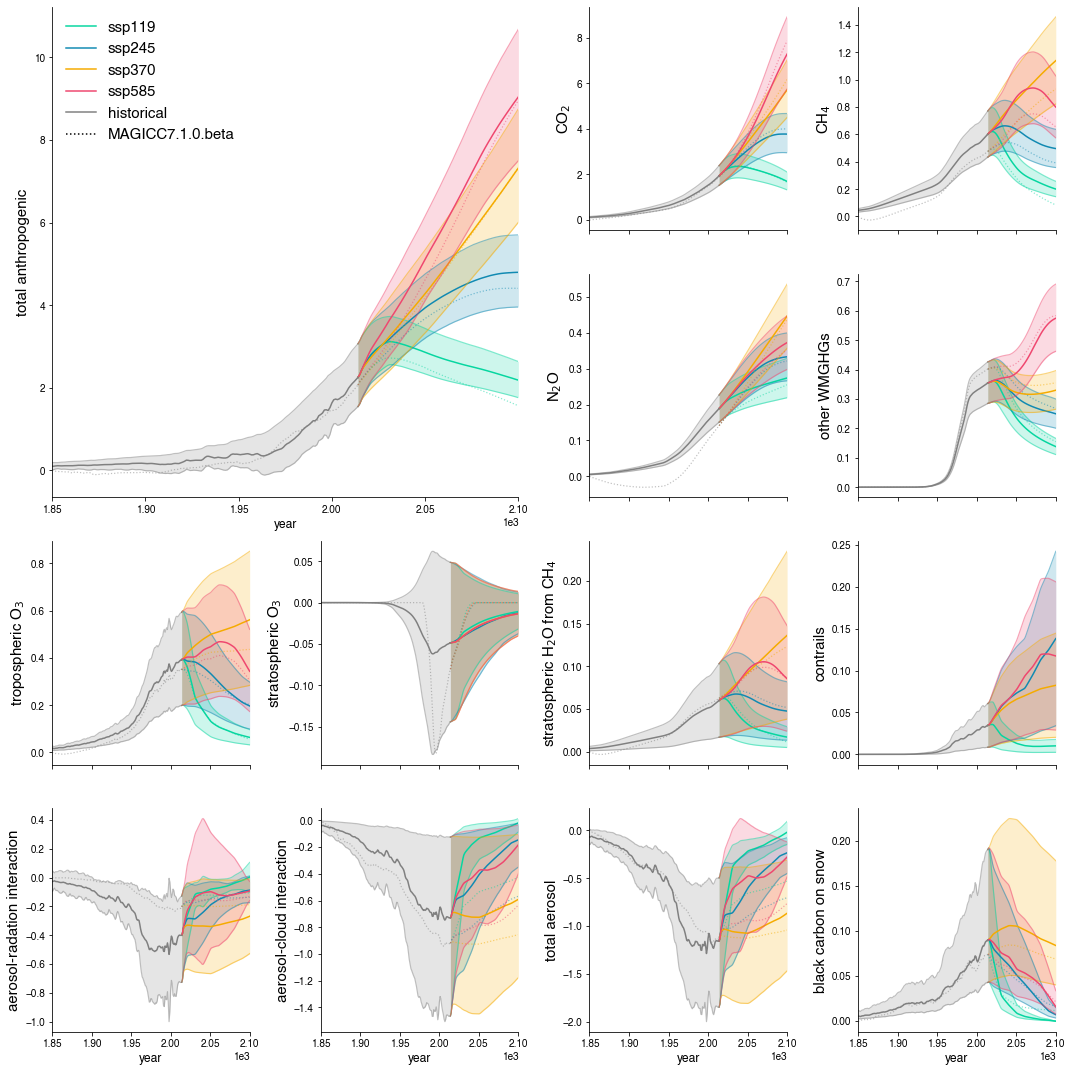

In [217]:
fig=plt.figure(figsize=(15,15))

map_forc_cat = dict(zip(param_categories.keys(),['other WMGHGs','CO$_2$','CH$_4$','N$_2$O','tropospheric O$_3$','stratospheric O$_3$','stratospheric H$_2$O from CH$_4$','aerosol-radation interaction','aerosol-cloud interaction','total aerosol','black carbon on snow','contrails']))
forc_cat_order = ['carbon_dioxide', 'methane', 'nitrous_oxide','other_wmghgs','trop_o3', 'strat_o3', 'strat_h2o','contrails','ari', 'aci', 'aer','bc_on_snow']

gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[:2,:2])
ax2 = [fig.add_subplot(gs[i,j]) for i in np.arange(4) for j in np.arange(4) if (i>=2) or (j>=2)]
colors= {'ssp245':'#118ab2','ssp370':'#F5AB00','ssp585':'#ef476f','ssp119':'#06d6a0','history':'grey'}
for ssp in scenarios:
    ax1.plot(plot_results.loc[2014:2100,(ssp,'anthro',50)],color=colors[ssp],label=ssp)
    ax1.fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,'anthro',[5,95])].values.T,color=colors[ssp],lw=0,alpha=0.2)
    ax1.plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,'anthro',[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
    
    ax1.plot(magicc_data.loc[2014:2100].index,magicc_data.loc[2014:2100,(ssp,'anthro')],color=colors[ssp],ls=':',lw=1.2,alpha=0.5)
    
    for i,forc_cat in enumerate(forc_cat_order):
        ax2[i].plot(plot_results.loc[2014:2100,(ssp,forc_cat,50)],color=colors[ssp])
        ax2[i].fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,forc_cat,[5,95])].values.T,color=colors[ssp],lw=0,alpha=0.2)
        ax2[i].plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,forc_cat,[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
        
        ax2[i].plot(magicc_data.loc[2014:2100].index,magicc_data.loc[2014:2100,(ssp,forc_cat)],color=colors[ssp],ls=':',lw=1.2,alpha=0.5)
        
ax1.plot(plot_results.loc[:2014,(ssp,'anthro',50)],color=colors['history'],label='historical')
ax1.fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,'anthro',[5,95])].values.T,color=colors['history'],lw=0,alpha=0.2)
ax1.plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,'anthro',[5,95])],color=colors['history'],lw=1.2,alpha=0.5)

ax1.plot(magicc_data.loc[:2014].index,magicc_data.loc[:2014,(ssp,'anthro')],color=colors['history'],ls=':',lw=1.2,alpha=0.5)

for i,forc_cat in enumerate(forc_cat_order):
        ax2[i].plot(plot_results.loc[:2014,(ssp,forc_cat,50)],color=colors['history'])
        ax2[i].fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,forc_cat,[5,95])].values.T,color=colors['history'],lw=0,alpha=0.2)
        ax2[i].plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,forc_cat,[5,95])],color=colors['history'],lw=1.2,alpha=0.5)
        
        ax2[i].plot(magicc_data.loc[:2014].index,magicc_data.loc[:2014,(ssp,forc_cat)],color=colors['history'],ls=':',lw=1.2,alpha=0.5)
        
        ax2[i].set_ylabel(map_forc_cat[forc_cat],fontsize=15)

        
ax1.set_ylabel('total anthropogenic',fontsize=15)
[a.tick_params(labelbottom=False) for a in ax2[:-4]]
[a.set_xlabel('year',fontsize=12) for a in ax2[-4:]+[ax1]]
[a.spines[pos].set_visible(False) for a in ax2+[ax1] for pos in ['right','top']]
[a.set_xlim(1850,2100) for a in ax2+[ax1]]
ax1.plot([],[],'k:',label='MAGICC7.1.0.beta')
ax1.legend(loc='upper left',fontsize=15)
plt.tight_layout()

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_ERF_grid.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

In [9]:
## Import some temperature data
baseline = ['1850','1900']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [33]:
## get some CMIP6 model data

## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]
            
baseline = [1861,1880]

plot_cmip6_tas2100 = ssp_tas.drop(('KACE-1-0-G','r3i1p1f1'),axis=1).groupby(level=(0,2),axis=1).mean()
plot_cmip6_tas2100 = plot_cmip6_tas2100 - plot_cmip6_tas2100.loc[baseline[0]:baseline[1]].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [65]:
CMIP6_ssp_statistics = plot_cmip6_tas2100.loc[2081:2100].T.drop_duplicates().T.mean().groupby(level=1).describe(percentiles=[0.166,0.5,0.833])

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


[None, None, None]

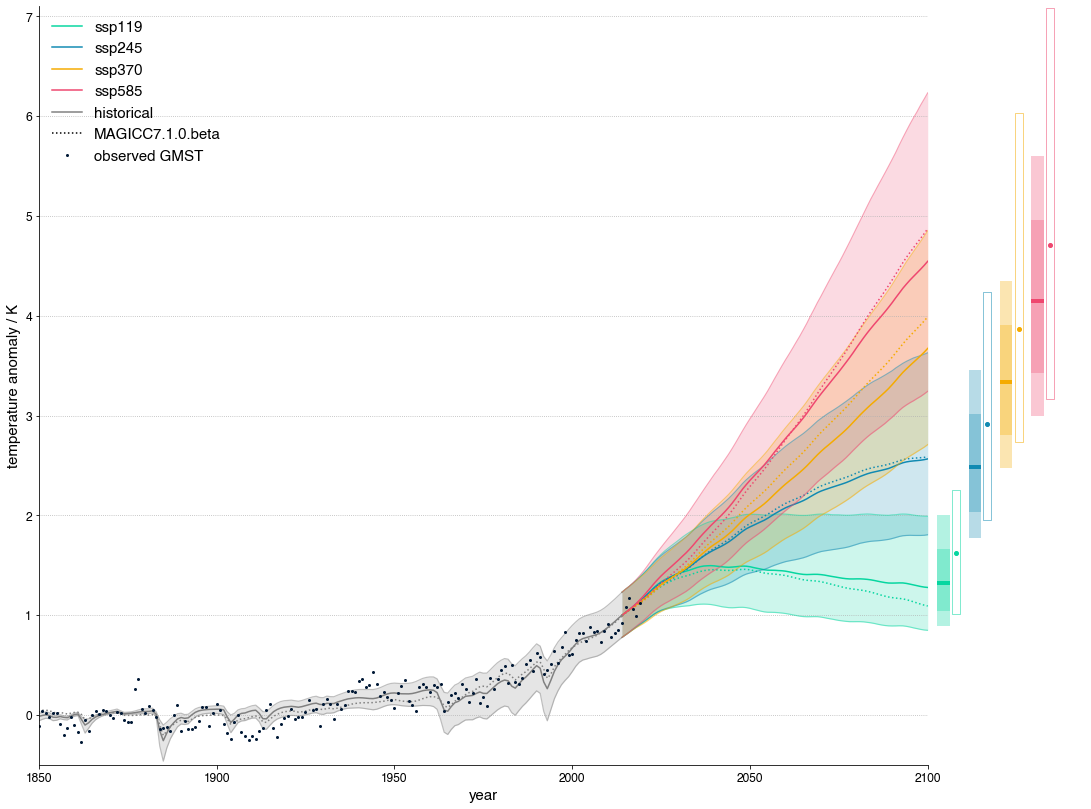

In [218]:
fig = plt.figure(figsize=(15,11.25))
gs = fig.add_gridspec(1, 20,wspace=0)
ax = fig.add_subplot(gs[0,:-3])

for ssp in scenarios:
    ax.plot(plot_results.loc[2014:2100,(ssp,'temp',50)],color=colors[ssp],label=ssp)
    ax.fill_between(plot_results.loc[2014:2100].index,*plot_results.loc[2014:2100,(ssp,'temp',[5,95])].values.T,color=colors[ssp],alpha=0.2,lw=0)
    ax.plot(plot_results.loc[2014:2100].index,plot_results.loc[2014:2100,(ssp,'temp',[5,95])],color=colors[ssp],lw=1.2,alpha=0.5)
    ax.plot(magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(2014,2101)]-magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1861,1880)].mean(),color=colors[ssp],ls=':')
    
ax.plot(plot_results.loc[:2014,(ssp,'temp',50)],color=colors['history'],label='historical')
ax.fill_between(plot_results.loc[:2014].index,*plot_results.loc[:2014,(ssp,'temp',[5,95])].values.T,color=colors['history'],alpha=0.2,lw=0)
ax.plot(plot_results.loc[:2014].index,plot_results.loc[:2014,(ssp,'temp',[5,95])],color=colors['history'],lw=1.2,alpha=0.5)
ax.plot(magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1850,2015)]-magicc_scm.loc['World'].xs('Surface Air Temperature Change',level=1).loc['esm-'+ssp+'-allGHG',range(1861,1880)].mean(),color=colors['history'],ls=':')
    
ax.plot([],[],'k:',label='MAGICC7.1.0.beta')
    
ax.plot(np.arange(1850,2020),(GMST_datasets - GMST_datasets.loc['1861':'1880'].mean()).loc[:'2019'].mean(axis=1).resample('y').mean().values,'.',ms=4,label='observed GMST')

ax1 = fig.add_subplot(gs[0,-3:])

for i,ssp in enumerate(scenarios):
    
    ax1.bar(i,0.04,width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',50)].mean()-0.02,color=colors[ssp])
    ax1.bar(i,plot_results.loc[2081:2100,(ssp,'temp',[16.6,83.3])].mean().diff(),width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',16.6)].mean(),color=colors[ssp],alpha=0.3)
    ax1.bar(i,plot_results.loc[2081:2100,(ssp,'temp',[5,95])].mean().diff(),width=0.4,bottom=plot_results.loc[2081:2100,(ssp,'temp',5)].mean(),color=colors[ssp],alpha=0.3)
    
    ax1.bar([i+0.4],CMIP6_ssp_statistics.loc[ssp,['min','max']].diff(),width=0.25,bottom=CMIP6_ssp_statistics.loc[ssp,'min'],color='',edgecolor=colors[ssp],lw=0.5)
    ax1.plot([i+0.4],CMIP6_ssp_statistics.loc[ssp,'50%'],'o',ms=4,c=colors[ssp])

ax.yaxis.grid(ls=':')
ax.set_ylim(-0.5,7.1)
ax1.set_ylim(-0.5,7.1)
ax1.axis('off')
[ax.spines[pos].set_visible(False) for pos in ['right','top']]
ax.set_xlim(1850,2100)
ax1.set_xlim(-0.5,4.5)
ax.legend(loc='upper left',fontsize=15)
plt.tight_layout()
ax.set_ylabel('temperature anomaly / K',fontsize=15)
ax.set_xlabel('year',fontsize=15)
ax.tick_params(labelsize=12)
ax.ticklabel_format(style="plain")

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_NROY_temp.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Default parameter historical run

In [219]:
## import concentrations:
CMIP6_conc_ftp = ftplib.FTP('data.iac.ethz.ch','anonymous')
CMIP6_conc_ftp.cwd('CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701')
CMIP6_ftp_list = [x for x in CMIP6_conc_ftp.nlst() if x[-3:]=='csv']
WMGHG_concs = pd.DataFrame(dict(zip(['_'.join(x.split('_')[3:-8]) for x in CMIP6_ftp_list],[pd.read_csv('ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/'+x,usecols=[0,1],index_col=0).iloc[:,0] for x in CMIP6_ftp_list])))
WMGHG_concs = WMGHG_concs[[x for x in WMGHG_concs.columns if x[-2:]!='eq']] # remove "equivalent" concentrations

WMGHG_concs['halon1202'] = 0
WMGHG_concs.loc[1765:2014,'halon1202'] = pd.read_csv('http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_MIDYEAR_CONCENTRATIONS.DAT',skiprows=38,delim_whitespace=True,index_col=0)['HALON1202'].loc[1765:2014].values

NOAA_mole_fractions_2020 = pd.read_csv('https://www.esrl.noaa.gov/gmd/aggi/NOAA_MoleFractions_2020.csv',skiprows=2,index_col=0,skipfooter=5).iloc[1:].replace('nd',np.nan).apply(pd.to_numeric)

scale_factor = (WMGHG_concs.loc[2014,'carbon_dioxide'] / NOAA_mole_fractions_2020.loc[2014:2015,'CO2']).values

CO2_concs = pd.Series(np.append(WMGHG_concs.loc[1750:,'carbon_dioxide'].values.flatten(),NOAA_mole_fractions_2020.loc[2015:,'CO2']*scale_factor),index=np.arange(1750,2020),name='CO2')

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [234]:
scenarios = ['ssp'+x for x in ['119','245','585','370']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=scenarios,axis=1).interpolate()
ssp_emms = ssp_emms.loc[1750:2300] - ssp_emms.loc[1750]
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=scenarios,axis=1).interpolate().loc[1750:2300]

for ssp in ssp_emms.columns.levels[0]:
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
    ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [235]:
default_gas_params = pd.read_csv("../Parameter_Sets/Complete_gas_cycle_params.csv",header=[0,1],index_col=0)

In [236]:
default_ssp_run = run_GIR(emissions_in=ssp_emms,forcing_in=ssp_forc,gas_parameters=default_gas_params)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|strat_o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|strat_o3', 'cfc114', 'cfc114|strat_o3', 'cfc115', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12', 'cfc12|strat_o3', 'ch2cl2', 'ch3ccl3', 'ch3ccl3|strat_o3', 'chcl3', 'co', 'co|trop_o3', 'halon1202', 'halon1202|strat_o3', 'halon1211', 'halon1211|strat_o3', 'halon1301', 'halon1301|strat_o3', 'halon2402', 'halon2402|strat_o3', 'hcfc141b', 'hcfc141b|strat_o3', 'hcfc142b', 'hcfc142b|strat_o3', 'hcfc22', 'hcfc22|strat_o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|trop_o3', 'methyl_bromide', 'methyl_bromide|strat_o3', 'methyl_chloride', 'methyl_chloride|strat_o3', 'nf3', 

100%|██████████| 550/550 [00:00<00:00, 3404.14 timestep/s]


[None, None, None]

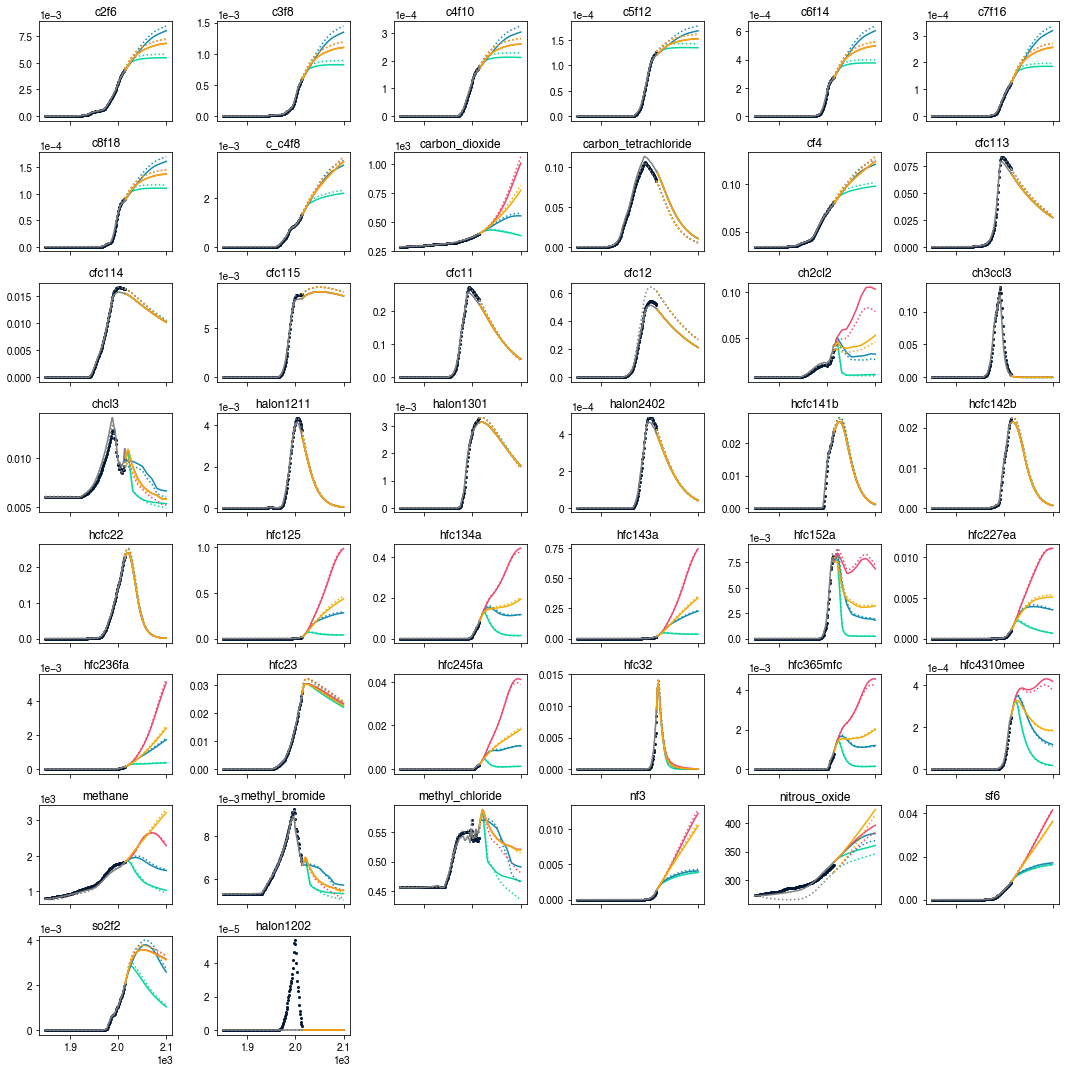

In [298]:
fig,ax = plt.subplots(8,6,figsize=(15,15))

for i,gas in enumerate(WMGHG_concs.columns):
    if gas in ['nitrous_oxide','carbon_dioxide','methane']:
        ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas],'.',ms=4,)
    else:
        ax.flatten()[i].plot(WMGHG_concs.loc[1850:,gas]/1000,'.',ms=4,)
        
    for ssp in scenarios:
        ax.flatten()[i].plot(default_ssp_run['C'].loc[2014:2100,(ssp,'default',gas)],color=colors[ssp])
        
        ax.flatten()[i].plot(magicc_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(2014,2101)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors[ssp],ls=':')
        
    ax.flatten()[i].plot(default_ssp_run['C'].loc[1850:2014,('ssp245','default',gas)],color=colors['history'])
    ax.flatten()[i].plot(magicc_scm.loc[('World','esm-'+ssp+'-allGHG',GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_key']),range(1850,2015)]*GIR_to_RCMIP_map.loc[gas,'RCMIP_concs_scaling'],color=colors['history'],ls=':')
    ax.flatten()[i].set_title(gas)
    
[a.tick_params(labelbottom=False) for a in ax[:-1].flatten()]
    
plt.tight_layout()

[a.set_visible(False) for a in ax.flatten()[-4:]]

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/SSP_concs.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Default parameter RCP run:_

In [11]:
## RCMIP SSP emissions:
scenarios = ['rcp'+x for x in ['26','45','60','85']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
rcp_emms = pd.concat([RCMIP_to_GIR_input_emms(x).dropna(axis=1,how='all').dropna() for x in scenarios],keys=scenarios,axis=1).interpolate()
rcp_emms = rcp_emms.loc[1750:2150] - rcp_emms.loc[1765]
rcp_forc = pd.concat([get_RCMIP_forc(x,drivers=['Radiative Forcing|Natural','Radiative Forcing|Anthropogenic|Albedo Change']) for x in scenarios],keys=scenarios,axis=1).interpolate().loc[1765:2150]

# ## switch in GCP co2 emissions up to start of SSPs
# GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# # set 1750 value to 0
# GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# # linearly interpolate between 0 and first land-use-change datapoint
# GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

# for ssp in ssp_emms.columns.levels[0]:
#     sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
#     ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
#     ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [12]:
rcp_run1 = run_GIR(emissions_in=rcp_emms,forcing_in=rcp_forc,gas_parameters=pd.concat([default_params.reindex([x for x in default_params.columns if x.split('|')[0] in rcp_emms.columns.levels[-1]],axis=1)],axis=1,keys=['default']),thermal_parameters=default_thermal)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c6f14', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch3ccl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc227ea', 'hfc23', 'hfc245fa', 'hfc32', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nitrous_oxide', 'sf6', 'halon1202', 'so2', 'nox', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|trop_o3', 'methane|strat_h2o', 'co|trop_o3', 'nox|trop_o3', 'nmvoc|trop_o3', 'bc|bc_on_snow', 'so2|aci', 'bc|aci', 'oc|aci', 'carbon_tetrachloride|strat_o3', 'cfc113|strat_o3', 'cfc114|strat_o3', 'cfc115|strat_o3', 'cfc11|strat_o3', 'cfc12|strat_o3', 'ch3ccl3|strat_o3', 'halon1211|strat_o3', 'halon1301|strat_o3', 'halon2402|strat_o3', 'hcfc141b|strat_o3', 'hcfc142b|strat_o3', 'hcfc22|strat_o3', 'methyl_bromide|strat_o3', 'methyl_chloride|strat_o3', 'halon1202|strat_o3'] for

100%|██████████| 385/385 [00:00<00:00, 3357.76 timestep/s]


In [1]:
rcp_run1['C'].xs('methane',axis=1,level=-1).plot()

NameError: name 'rcp_run1' is not defined